# 08. Create heatmaps of test statistics

In [14]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from matplotlib.colors import DivergingNorm
import matplotlib
import scipy.stats
from scipy.stats import norm
import sys

In [15]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'PiYG',
    'axes.linewidth': 0.25,
    'axes.grid': False,
    'savefig.dpi': 400,
    'axes.labelsize': 7,
    'axes.titlesize': 9,
    'axes.facecolor': 'white',
    'xtick.major.size': 2,
    'ytick.major.width': 0.25,
    'ytick.major.size': 2,
    'xtick.major.width': 0.25,
    'xtick.major.pad': '4',
    'ytick.major.pad': '4',
    'xtick.minor.size': 2,
    'ytick.minor.width': 0.25,
    'ytick.minor.size': 2,
    'xtick.minor.width': 0.25,
    'font.size': 7, 
    'legend.fontsize': 7,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'lines.linewidth': 0.25,
    'patch.linewidth': 0.25,
    # 'text.usetex': True,
    'figure.figsize': [7, 7],
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial'
}
matplotlib.rcParams.update(params)


def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    
    return cbar

## 1) Create a heatmap of P-values based on z-scores

In [3]:
def get_simple():
    merged_df = pd.read_csv('data/RO_RE.csv')
    test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

    col_list = list(test_dat.columns[2:])
    res = test_dat.groupby([test_dat.total_exp, pd.cut(test_dat.total_obs,
                                                       [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, np.inf],
                                                       labels=[0, 1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10, 11, 12])])[col_list].sum().reset_index()

    test_dat = res.groupby([res.total_obs, pd.cut(res.total_exp, [-np.inf, 0, 1, 2, np.inf],
                                                  labels=[0, 1, 2, 3])])[col_list].sum().reset_index()

    test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
    test_dat['rand_std'] = test_dat.iloc[:, 3:203].std(axis=1)
    test_dat['z_score'] = norm.ppf(norm.cdf(x=test_dat['E'], loc=test_dat['rand_mean'],
                                            scale=test_dat['rand_std']))
    test_dat['p_val'] = 1 - norm.cdf(test_dat['z_score'])
    test_dat = test_dat.round({"rand_mean": 2, "rand_std": 2, "z_score": 3, "p_val": 3})
    piv = pd.pivot_table(test_dat, values="p_val", index=["total_exp"], columns=["total_obs"])
    
    return piv


def get_strict():
    merged_df = pd.read_csv('data/SO_SE.csv')
    test_dat = merged_df.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)

    col_list = list(test_dat.columns[2:])
    res = test_dat.groupby([test_dat.sev_exp, pd.cut(test_dat.total_obs,
                                                     [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, np.inf],
                                                     labels=[0, 1, 2, 3, 4,
                                                             5, 6, 7, 8, 9])])[col_list].sum().reset_index()

    test_dat = res.groupby([res.total_obs, pd.cut(res.sev_exp,[-np.inf, 0, 1, np.inf],
                                                  labels=[0, 1, 2])])[col_list].sum().reset_index()

    test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
    test_dat['rand_std'] = test_dat.iloc[:, 3:203].std(axis=1)
    test_dat['z_score'] = norm.ppf(norm.cdf(x=test_dat['E'], loc=test_dat['rand_mean'],
                                            scale=test_dat['rand_std']))
    test_dat['p_val'] = 1 - norm.cdf(test_dat['z_score'])
    test_dat = test_dat.round({"rand_mean": 2, "rand_std": 2, "z_score": 3, "p_val": 3})
    piv = pd.pivot_table(test_dat, values="p_val", index=["sev_exp"], columns=["total_obs"])
    
    return piv


def plot_heatmap(ax, piv, xticks, yticks, title):
    colnorm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)
    img1 = ax.imshow(piv, alpha=0.8, norm=colnorm)
    ax.set_xticks(np.arange(piv.shape[1]))
    ax.set_xticklabels(xticks)
    ax.set_yticks(np.arange(piv.shape[0]))
    ax.set_yticklabels(yticks)
    ax.title.set_text(title)
    ax.set_xlabel(r'Observation of $n_o$ cheaters')
    ax.set_ylabel(r'Victimization by $n_v$ cheaters')

    textcolors = ["k", "w"]
    for x in range(piv.shape[1]):
        for y in range(piv.shape[0]):
            if np.isnan(piv.iloc[y, x]) == False:
                text = ax.text(x, y, ('%.3f' % piv.iloc[y, x]).lstrip('0'), ha="center", va="center",
                               color=textcolors[1 if piv.iloc[y, x] <= 0.01 or piv.iloc[y, x] >= 0.85 else 0])

    cbar = colorbar(img1)
    cbar.solids.set_edgecolor("face")

total_obs     0      1      2      3      4      5      6      7      8   \
total_exp                                                                  
0          0.171  0.953  0.504  0.651  0.173  0.829  0.688  0.050  0.628   
1          0.522  0.176  0.354  0.161  0.932  0.478  0.697  0.698  0.254   
2          0.560  0.633  0.744  0.019  0.880  0.001  0.629  0.306  0.821   
3          0.309  0.613  0.458  0.138  0.043  0.900  0.911  0.008  0.590   

total_obs     9      10     11     12  
total_exp                              
0          0.012  0.935  0.122  0.189  
1          0.992  0.286  0.754  0.739  
2          0.079  0.472  0.023  0.808  
3          0.345  0.287  0.938  0.068  
total_obs      0      1      2      3      4      5      6      7      8  \
sev_exp                                                                    
0          0.725  0.722  0.860  0.319  0.258  0.134  0.252  0.932  0.029   
1          0.855  0.029  0.309  0.083  0.807  0.375  0.269  0.128  0.377   

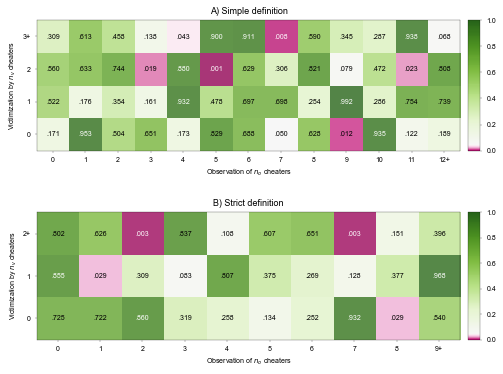

In [6]:
# Plot a heatmap of P-values (z-scores).
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5.4))

piv1 = get_simple()
print(piv1)
xticks1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, '12+']
yticks1 = [0, 1, 2, '3+']
plot_heatmap(ax1, piv1, xticks1, yticks1, 'A) Simple definition')

piv2 = get_strict()
print(piv2)
xticks2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, '9+']
yticks2 = [0, 1, '2+']
plot_heatmap(ax2, piv2, xticks2, yticks2, 'B) Strict definition')
plt.tight_layout()
plt.show()
# fig.savefig('figs/z-scores/z_score_p_val.png')

## 2) Plot a heatmap of P-values based on Poisson statistics 

total_obs     0      1      2      3      4      5      6      7      8   \
total_exp                                                                  
0          0.330  0.798  0.512  0.618  0.273  0.784  0.671  0.108  0.631   
1          0.530  0.268  0.406  0.220  0.904  0.508  0.706  0.701  0.314   
2          0.578  0.708  0.780  0.059  0.894  0.008  0.678  0.374  0.855   
3          0.391  1.000  0.597  0.246  0.116  1.000  1.000  0.045  0.677   

total_obs     9      10     11     12  
total_exp                              
0          0.056  0.935  0.198  0.311  
1          0.987  0.342  0.795  0.692  
2          0.138  0.536  0.058  0.806  
3          0.441  0.371  1.000  0.211  
total_obs      0      1      2      3      4      5      6      7      8  \
sev_exp                                                                    
0          0.600  0.645  0.760  0.386  0.353  0.200  0.330  0.925  0.121   
1          0.807  0.095  0.375  0.147  0.805  0.426  0.346  0.217  0.457   

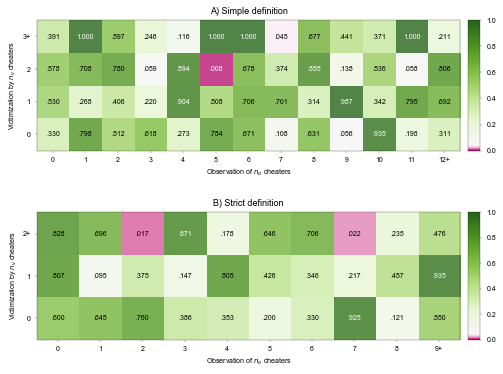

In [7]:
def get_simple_poiss():
    merged_df = pd.read_csv('data/RO_RE.csv')
    test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

    col_list = list(test_dat.columns[2:])
    res = test_dat.groupby([test_dat.total_exp, pd.cut(test_dat.total_obs,
                                                       [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, np.inf],
                                                       labels=[0, 1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10, 11, 12])])[col_list].sum().reset_index()

    test_dat = res.groupby([res.total_obs, pd.cut(res.total_exp,[-np.inf, 0, 1, 2, np.inf],
                                                  labels=[0, 1, 2, 3])])[col_list].sum().reset_index()

    test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
    test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
    test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
    test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

    test_dat = test_dat.round({"rand_mean": 2, "cdf": 3, "pmf": 3, "prob": 3})

    piv = pd.pivot_table(test_dat, values="prob", index=["total_exp"], columns=["total_obs"])

    return piv


def get_strict_poiss():
    merged_df = pd.read_csv('data/SO_SE.csv')
    test_dat = merged_df.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)

    col_list = list(test_dat.columns[2:])
    res = test_dat.groupby([test_dat.sev_exp, pd.cut(test_dat.total_obs,
                                                     [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, np.inf],
                                                     labels=[0, 1, 2, 3, 4,
                                                             5, 6, 7, 8, 9])])[col_list].sum().reset_index()

    test_dat = res.groupby([res.total_obs, pd.cut(res.sev_exp, [-np.inf, 0, 1, np.inf],
                                                  labels=[0, 1, 2])])[col_list].sum().reset_index()

    test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
    test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
    test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
    test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

    test_dat = test_dat.round({"rand_mean": 2, "cdf": 3, "pmf": 3, "prob": 3})

    piv = pd.pivot_table(test_dat, values="prob", index=["sev_exp"], columns=["total_obs"])

    return piv


# Plot a heatmap of P-values (Poisson).
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5.4))

piv1 = get_simple_poiss()
print(piv1)
xticks1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, '12+']
yticks1 = [0, 1, 2, '3+']
plot_heatmap(ax1, piv1, xticks1, yticks1, 'A) Simple definition')

piv2 = get_strict_poiss()
print(piv2)
xticks2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, '9+']
yticks2 = [0, 1, '2+']
plot_heatmap(ax2, piv2, xticks2, yticks2, 'B) Strict definition')
plt.tight_layout()
plt.show()
# fig.savefig('figs/Poisson_stats/poiss_p_val.png')

## 3) Calculate the P-values of each motif - (1, 0), (0, 1), and (1, 1).

### 3-1) Calculate the test statistics - strict def. of experience and observation.

Count the total number of the motif (0, 1).

In [28]:
class InvalidFileError(Exception):
    pass


def count_pure_obs_motifs(file_name):
    try:
        if file_name == 'data/RO_RE.csv':
            merged_df = pd.read_csv(file_name)

            # Drop the rows with zero experience or zero observation.
            test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.total_exp == 0)].index)
            test_dat = test_dat.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

            # Calculate the test statistics of the motif (0, 1).
            test_dat = test_dat[test_dat.total_exp == 0]

        if file_name == 'data/SO_SE.csv':
            merged_df = pd.read_csv(file_name)

            # Drop the rows with zero experience or zero observation.
            test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.sev_exp == 0)].index)
            test_dat = test_dat.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)

            test_dat = test_dat[test_dat.sev_exp == 0]

        if file_name != 'data/RO_RE.csv' and file_name != 'data/SO_SE.csv':
            raise InvalidFileError()

    except InvalidFileError:
        print("Invalid filename")

    else:
        temp_dat = test_dat.loc[:, 'E':].multiply(test_dat['total_obs'], axis="index")
        temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
        cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
        cum_prop = round(cnt/200, 2)

        rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
        rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
        z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0], loc=rand_mean, scale=rand_std))
        p_val = 1 - norm.cdf(z_score)
        cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
        pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
        prob = 1 - cdf + pmf

        print("rand_mean: " + str(round(rand_mean, 3)))
        print("rand_std: " + str(round(rand_std, 3)))
        print("z-score: " + str(round(z_score, 3)))
        print("p_val (z-score): " + str(p_val))
        print("cdf: " + str(round(cdf, 3)))
        print("pmf: " + str(round(pmf, 3)))
        print("prob (Poisson p-value): " + str(prob))
        print("cum_prop: " + str(cum_prop))

        return round(p_val, 3)

In [29]:
sim_pure_obs = count_pure_obs_motifs('data/RO_RE.csv')
print()
str_pure_obs = count_pure_obs_motifs('data/SO_SE.csv')

rand_mean: 3271.615
rand_std: 77.553
z-score: 1.359
p_val (z-score): 0.08709260311270528
cdf: 0.967
pmf: 0.001
prob (Poisson p-value): 0.03385392789821685
cum_prop: 0.08

rand_mean: 1619.985
rand_std: 35.225
z-score: 0.653
p_val (z-score): 0.25675749503458845
cdf: 0.721
pmf: 0.008
prob (Poisson p-value): 0.28697775676405557
cum_prop: 0.27


Count the total number of the motif (1, 0).

In [26]:
def count_pure_exp_motifs(file_name):
    try:
        if file_name == 'data/RO_RE.csv':
            merged_df = pd.read_csv(file_name)
            test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.total_exp == 0)].index)
            test_dat = test_dat.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

            # Calculate the test statistics of the motif (1, 0).
            test_dat = test_dat[test_dat.total_obs == 0]
            temp_dat = test_dat.loc[:, 'E':].multiply(test_dat['total_exp'], axis="index")

        if file_name == 'data/SO_SE.csv':
            merged_df = pd.read_csv(file_name)
            test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.sev_exp == 0)].index)
            test_dat = test_dat.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)
            test_dat = test_dat[test_dat.total_obs == 0]
            temp_dat = test_dat.loc[:, 'E':].multiply(test_dat['sev_exp'], axis="index")

        if file_name != 'data/RO_RE.csv' and file_name != 'data/SO_SE.csv':
            raise InvalidFileError()
    
    except InvalidFileError:
        print("Invalid filename")
    
    else:
        temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
        cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
        cum_prop = round(cnt/200, 2)

        rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
        rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
        z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0], loc=rand_mean, scale=rand_std))
        p_val = 1 - norm.cdf(z_score)
        cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
        pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
        prob = 1 - cdf + pmf

        print("rand_mean: " + str(round(rand_mean, 3)))
        print("rand_std: " + str(round(rand_std, 3)))
        print("z-score: " + str(round(z_score, 3)))
        print("p_val (z-score): " + str(round(p_val, 3)))
        print("cdf: " + str(round(cdf, 3)))
        print("pmf: " + str(round(pmf, 3)))
        print("prob: " + str(round(prob, 3)))
        print("cum_prop: " + str(round(cum_prop, 3)))

        return round(p_val, 3)

In [27]:
sim_pure_exp = count_pure_exp_motifs('data/RO_RE.csv')
print()
str_pure_exp = count_pure_exp_motifs('data/SO_SE.csv')

rand_mean: 187.675
rand_std: 10.795
z-score: 0.308
p_val (z-score): 0.379
cdf: 0.614
pmf: 0.028
prob: 0.414
cum_prop: 0.4

rand_mean: 79.3
rand_std: 7.182
z-score: -1.434
p_val (z-score): 0.924
cdf: 0.135
pmf: 0.024
prob: 0.889
cum_prop: 0.94


Count the total number of the motif (1, 1).

In [24]:
def count_mixed_motifs(file_name):
    try:
        if file_name == 'data/RO_RE.csv':
            merged_df = pd.read_csv(file_name)
            test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) | (merged_df.total_exp == 0)].index)
            test_dat = test_dat.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
            test_dat['num_pairs'] = np.where(test_dat['total_obs'] <= test_dat['total_exp'],
                                             test_dat['total_obs'], test_dat['total_exp'])

            temp_dat = test_dat.loc[:, 'E':'R200'].multiply(test_dat['num_pairs'], axis="index")

        if file_name == 'data/SO_SE.csv':
            merged_df = pd.read_csv(file_name)
            test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) | (merged_df.sev_exp == 0)].index)
            test_dat = test_dat.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)
            test_dat['num_pairs'] = np.where(test_dat['total_obs'] <= test_dat['sev_exp'],
                                             test_dat['total_obs'], test_dat['sev_exp'])

            temp_dat = test_dat.loc[:, 'E':'R200'].multiply(test_dat['num_pairs'], axis="index")

        if file_name != 'data/RO_RE.csv' and file_name != 'data/SO_SE.csv':
            raise InvalidFileError()

    except InvalidFileError:
        print("Invalid filename")

    else:
        # Calculate the total number of the motif (1, 1) for each network.
        temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
        # print(temp_dat.tail(1))
        # print(temp_dat.iloc[-1, 0])
        # print(temp_dat.iloc[-1, 1:].values)
        cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
        cum_prop = round(cnt/200, 2)

        # Calculate p-values.
        rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
        rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
        z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0], loc=rand_mean, scale=rand_std))
        p_val = 1 - norm.cdf(z_score)
        cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
        pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
        prob = 1 - cdf + pmf

        print("rand_mean: " + str(round(rand_mean, 3)))
        print("rand_std: " + str(round(rand_std, 3)))
        print("z-score: " + str(round(z_score, 3)))
        print("p_val (z-score): " + str(p_val))
        print("cdf: " + str(round(cdf, 3)))
        print("pmf: " + str(round(pmf, 3)))
        print("prob: " + str(prob))
        print("cum_prop: " + str(cum_prop))

    return round(p_val, 3)

In [25]:
sim_mixed_motifs = count_mixed_motifs('data/RO_RE.csv')
print()
str_mixed_motifs = count_mixed_motifs('data/SO_SE.csv')

rand_mean: 704.265
rand_std: 17.083
z-score: 2.092
p_val (z-score): 0.0182253597375861
cdf: 0.913
pmf: 0.006
prob: 0.0929006220878738
cum_prop: 0.01

rand_mean: 287.795
rand_std: 10.995
z-score: 4.02
p_val (z-score): 2.9057081599281886e-05
cdf: 0.995
pmf: 0.001
prob: 0.005793856883775075
cum_prop: 0.0


O      0      1
V              
0    NaN  0.087
1  0.379  0.018
O      0      1
V              
0    NaN  0.257
1  0.924  0.000


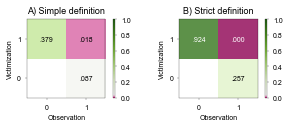

In [30]:
simple_df = pd.DataFrame({"O": [0, 0, 1, 1], 
                          "V": [0, 1, 0, 1], 
                          "p_val": [np.NaN, sim_pure_exp, sim_pure_obs, sim_mixed_motifs]})

strict_df = pd.DataFrame({"O": [0, 0, 1, 1], 
                          "V": [0, 1, 0, 1], 
                          "p_val": [np.NaN, str_pure_exp, str_pure_obs, str_mixed_motifs]})

simple_piv = pd.pivot_table(simple_df, values="p_val",index=["V"], columns=["O"])
print(simple_piv)

strict_piv = pd.pivot_table(strict_df, values="p_val",index=["V"], columns=["O"])
print(strict_piv)

def plot_small_heatmap(ax, piv, title):
    colnorm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)
    img1 = ax.imshow(piv, alpha=0.8, norm=colnorm)
    ax.set_xticks(np.arange(piv.shape[0]))
    ax.set_yticks(np.arange(piv.shape[1]))
    ax.title.set_text(title)
    ax.set_xlabel('Observation')
    ax.set_ylabel('Victimization')

    textcolors = ["k", "w"]
    for x in range(piv.shape[0]):
        for y in range(piv.shape[1]):
            if np.isnan(piv.iloc[y, x]) == False:
                text = ax.text(x, y, ('%.3f' % piv.iloc[y, x]).lstrip('0'), ha="center", va="center",
                               color=textcolors[1 if piv.iloc[y, x] <= 0.01 or piv.iloc[y, x] >= 0.85 else 0])

    cbar = colorbar(img1)
    cbar.solids.set_edgecolor("face")


# Plot a heatmap of P-values (z-scores).
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 1.6))
plt.subplots_adjust(bottom=0.2)
plot_small_heatmap(ax1, simple_piv, 'A) Simple definition')
plot_small_heatmap(ax2, strict_piv, 'B) Strict definition')
plt.show()
# fig.savefig('figs/motif_p_vals.png')

 ## 4) Plot the number of counts in cells.

In [8]:
simple_data = pd.read_csv('data/RO_RE.csv')
simple_data = simple_data.drop(simple_data[simple_data.total_obs > 20].index)
test_dat = simple_data.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
simple_freq = pd.pivot_table(test_dat, values="E", index=["total_exp"], columns=["total_obs"])
print(simple_freq)

strict_data = pd.read_csv('data/SO_SE.csv')
strict_data = strict_data.drop(strict_data[strict_data.total_obs > 20].index)
strict_data = strict_data.drop(strict_data[strict_data.sev_exp > 6].index)
test_dat = strict_data.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)
strict_freq = pd.pivot_table(test_dat, values="E", index=["sev_exp"], columns=["total_obs"])
print(strict_freq)

total_obs     0      1      2      3     4     5     6     7     8     9   \
total_exp                                                                   
0          183.0  381.0  214.0  130.0  97.0  52.0  36.0  37.0  19.0  22.0   
1          101.0   60.0   53.0   49.0  27.0  28.0  23.0  21.0  20.0   9.0   
2           22.0    2.0    4.0   14.0   5.0  13.0   6.0   8.0   5.0   9.0   
3            9.0    0.0    1.0    2.0   2.0   0.0   0.0   2.0   2.0   2.0   
4            1.0    NaN    0.0    0.0   1.0   0.0   0.0   2.0   0.0   0.0   
5            3.0    NaN    NaN    NaN   0.0   0.0   0.0   1.0   0.0   1.0   
6            0.0    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   
7            0.0    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   
8            NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   

total_obs  ...   11   12   13   14   15   16   17   18   19   20  
total_exp  ...                                                    
0          ...  9.

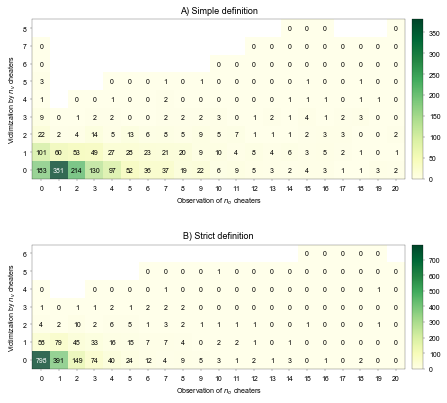

<Figure size 504x504 with 0 Axes>

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
img1 = ax1.imshow(simple_freq, cmap='YlGn', alpha=0.8)
ax1.set_xticks(np.arange(simple_freq.shape[1]))
ax1.set_yticks(np.arange(simple_freq.shape[0]))
ax1.set_xlabel(r'Observation of $n_o$ cheaters')
ax1.set_ylabel(r'Victimization by $n_v$ cheaters')
ax1.title.set_text('A) Simple definition')

textcolors = ["k", "w"]
for y in range(simple_freq.shape[0]):
    for x in range(simple_freq.shape[1]):
        if np.isnan(simple_freq[x][y]) == False:
            text = ax1.text(x, y, int(simple_freq[x][y]), ha="center", va="center",
                            color=textcolors[1 if simple_freq[x][y] >= 350 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")

img2 = ax2.imshow(strict_freq, cmap='YlGn', alpha=0.8)
ax2.set_xticks(np.arange(strict_freq.shape[1]))
ax2.set_yticks(np.arange(strict_freq.shape[0]))
ax2.set_xlabel(r'Observation of $n_o$ cheaters')
ax2.set_ylabel(r'Victimization by $n_v$ cheaters')
ax2.title.set_text('B) Strict definition')

textcolors = ["k", "w"]

for y in range(strict_freq.shape[0]):
    for x in range(strict_freq.shape[1]):
        if np.isnan(strict_freq[x][y]) == False:
            text = ax2.text(x, y, int(strict_freq[x][y]), ha="center", va="center",
                            color=textcolors[1 if strict_freq[x][y] >= 400 else 0])

cbar = colorbar(img2)
cbar.solids.set_edgecolor("face")

plt.show()
plt.tight_layout()
# fig.savefig('figs/freq.png')

## 5) Plot the Chi-square tests for the Poisson distributions.

In [20]:
simple_data = pd.read_csv('data/chi_sq/RO_RE_chi_sq_poiss.csv')
piv1 = pd.pivot_table(simple_data, values="pois_pval", index=["total_exp"], columns=["total_obs"])
print(piv1)

strict_data = pd.read_csv('data/chi_sq/SO_SE_chi_sq_poiss.csv')
piv2 = pd.pivot_table(strict_data, values="pois_pval", index=["total_exp"], columns=["total_obs"])
print(piv2)

total_obs     0      1      2      3      4      5      6      7      8   \
total_exp                                                                  
0          0.000  0.132  0.488  0.337  0.248  0.342  0.191  0.218  0.017   
1          0.431  0.401  0.685  0.390  0.658  0.217  0.918  0.689  0.381   
2          0.029  0.526  0.646  0.556  0.427  0.228  0.554  0.177  0.723   
3          0.116  0.865  0.569  0.943  0.201  0.119  0.254  0.836  0.911   

total_obs     9      10     11     12  
total_exp                              
0          0.014  0.338  0.296  0.012  
1          0.297  0.961  0.804  0.155  
2          0.601  0.278  0.664  0.786  
3          0.808  0.129  0.344  0.000  
total_obs      0      1      2      3      4      5      6      7      8  \
total_exp                                                                  
0          0.212  0.768  0.416  0.158  0.239  0.083  0.779  0.120  0.086   
1          0.157  0.018  0.174  0.832  0.436  0.806  0.672  0.015  0.313   

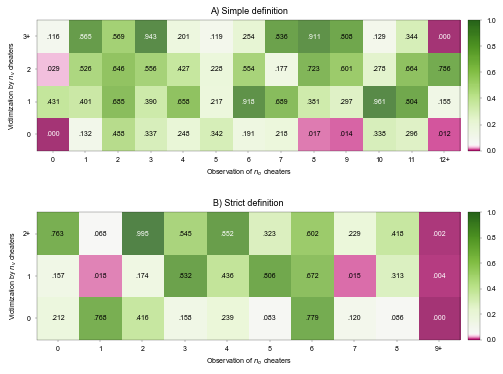

In [21]:
# Plot a heatmap of P-values (Poisson).
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5.4))

xticks1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, '12+']
yticks1 = [0, 1, 2, '3+']
plot_heatmap(ax1, piv1, xticks1, yticks1, 'A) Simple definition')

xticks2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, '9+']
yticks2 = [0, 1, '2+']
plot_heatmap(ax2, piv2, xticks2, yticks2, 'B) Strict definition')
plt.tight_layout()
plt.show()

## 6) Plot the Chi-square tests for the Normal distributions.

In [22]:
simple_data = pd.read_csv('data/chi_sq/RO_RE_chi_sq_norm.csv')
piv1 = pd.pivot_table(simple_data, values="norm_pval", index=["total_exp"], columns=["total_obs"])
print(piv1)

strict_data = pd.read_csv('data/chi_sq/SO_SE_chi_sq_norm.csv')
piv2 = pd.pivot_table(strict_data, values="norm_pval", index=["total_exp"], columns=["total_obs"])
print(piv2)

total_obs     0      1      2      3      4      5      6      7      8   \
total_exp                                                                  
0          0.851  0.229  0.323  0.679  0.000  0.444  0.000  0.241  0.219   
1          0.000  0.527  0.945  0.118  0.727  0.302  0.824  0.000  0.114   
2          0.000  0.408  0.000  0.509  0.090  0.000  0.073  0.000  0.000   
3          0.586  0.000  0.005  0.000  0.000  0.000  0.000  0.045  0.665   

total_obs     9      10     11     12  
total_exp                              
0          0.000  0.584  0.307  0.253  
1          0.381  0.735  0.274  0.961  
2          0.178  0.065  0.000  0.468  
3          0.409  0.007  0.382  0.408  
total_obs      0      1      2      3      4      5      6      7      8  \
total_exp                                                                  
0          0.000  0.000  0.000  0.396  0.440  0.000  0.771  0.701  0.823   
1          0.096  0.000  0.339  0.789  0.243  0.922  0.949  0.008  0.000   

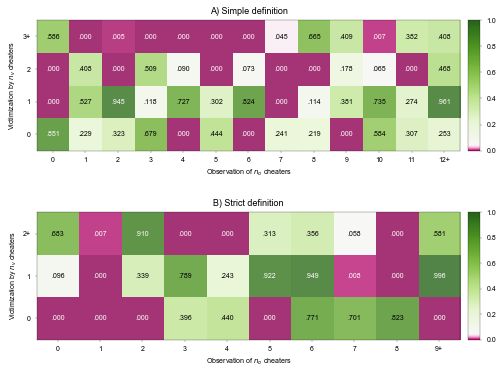

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5.4))

xticks1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, '12+']
yticks1 = [0, 1, 2, '3+']
plot_heatmap(ax1, piv1, xticks1, yticks1, 'A) Simple definition')

xticks2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, '9+']
yticks2 = [0, 1, '2+']
plot_heatmap(ax2, piv2, xticks2, yticks2, 'B) Strict definition')
plt.tight_layout()
plt.show()